#### Measurement Framework Library

# MFLib API Examples: Prometheus and Grafana
This notebook show how to get metrics from Prometheus using Grafana.

## Prerequisites
The slice has to have already been instrumentized. See the [Instrumentize a Slice](./instrumentize_a_slice.ipynb) notebook.

## General Imports

In [ ]:
import os
import json
import traceback

## Import MFLib
If you have trouble importing mflib it may be because:
* After you do the MFLib install, you will have to restart the notebook kernel before the importing of MFLib will work.
* When your Jupyter Hub server container is reloaded, the above install will may be removed. If you log out or have to restart the server you will get an import error when trying to import MFLib.
See [Install MFLib](./mflib_install.ipynb)


In [ ]:
# Check version
import mflib 
print(f"MFLib version  {mflib.__version__} " )

# Import MFLib Class
from mflib.mflib import MFLib

## Set Experiment Slice Name

#### If you are using the slice created in the Instrumentize a Slice notebook, you will have this instrumentized topology and slice name.

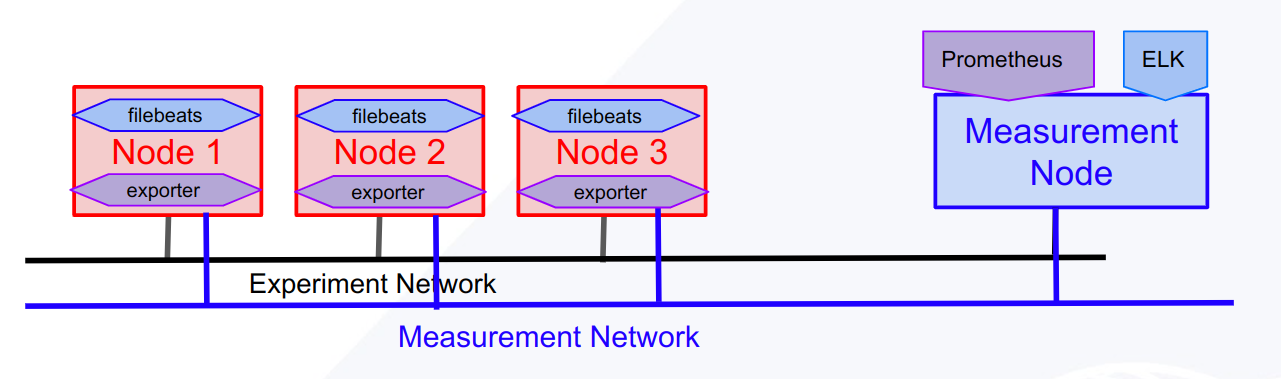

In [ ]:
# The slice name of the slice with which you want to interact.
slice_name = "MyMonitoredSlice"

## Create the MFLib Object
Create the new MFLib object by passing in the name of the slice with which you will be interacting.
This will take a few seconds. 
Note: If the slice has not been previously initialized and instrumentized then this step will attempt to initialize the slice. That will take ~ 5 minutes. However, as of this writing, if the slice is not instrumentized, instrumentize will not be performed.

In [ ]:
mf = MFLib(slice_name, mf_repo_branch="main")

# Prometheus
Prometheus consists of 3 basic parts:
* Prometheus client running on the Measurement Node. This client requests metrics from various exporters. 
* Exporters are servers that Prometheus contacts to get metrics. The node_exporter has been installed on each experient node.
* Grafana has been installed on the Measurement Node and provides a web GUI to visualize the gathered metrics. 

## Get Prometheus Grafana Access Info
To access the Prometheus Metrics go to the Grafana interface.  
From your local machine, you will have to tunnel through the bastion host into the measurement node.  
If you have added FABRIC_ALT_COPY_SSH_CONFIG and FABRIC_ALT_COPY_SLICE_PRIVATE_KEY_FILE to your fabric_rc file use `mf.grafana_tunnel` to get the SSH tunnel command.   

In [ ]:
# Grafana SSH Tunnel Command
# mf.grafana_tunnel_local_port = 10010 # optionally change the port
print(mf.grafana_tunnel)

print(f"Browse to https://localhost:{mf.grafana_tunnel_local_port}/grafana/dashboards?query=%2A")

Otherwise you will need to create the tunnel using:
`ssh -L <local-port>:localhost:443 -F <fabric-ssh-config-file> -i <your portal_slice_id_rsa-file> <slice-username>@<meas_node-ip>`

Browse to the link printed above.
You will need to accept the self-signed certificate.     
The Grafana view opens to the default user. 
To login as the admin click on the door icon at the bottom left and enter u: admin p: <grafana_admin_password (see below)

The Measurement Framework works with "services". The instrumentize command installs several default services. One is the grafana_manager. The grafana_manager service lets you write python scripts to interact with the Grafana server setup on the Measurement Node.

Use the mflib.info method to retrieve information from the grafana_manager.

In [ ]:
# The grafana_manager service was created by the mf.instrumentize call.
# Get access info for Grafana by using the mflib.info call to the grafana_manager.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["admin_password"]
# Call info using service name and data dictionary.
info_results = mf.info("grafana_manager", data)
print(info_results)

# Upload Dashboards to Grafana
It is possible to upload custom dashboards to Grafana using the grafana_manager.
This example installs a very simple dashboard to see the Prometheus scrape job's up status. 

Browse to the dashboards link created by the next cell.  
There should be a few default dashboards including Node Exporter Full, Network Traffic Dashboard and Ping Status.

In [ ]:
# Create browse all dashboards link
print(f"https://localhost:{mf.grafana_tunnel_local_port}/grafana/dashboards?query=%2A")

Upload the Up dashboard.  

In [ ]:
data = {}
data["commands"] = []
# Upload the dashboards
data["commands"].append( {"cmd":"upload_dashboards", "dashboard_filenames":["up.json"]} )
# Add the uploaded dashboards to Grafana
data["commands"].append({"cmd":"add_dashboards", "dashboard_filenames":["up.json"] } )

files = ["./dashboard_examples/grafana/up.json"]
mf.update("grafana_manager", data, files)

Refresh the dashboard page. You should see the addition of the Up dashboard.

For more avaialable dashboards see [mf-dashboards on GitHub](https://github.com/fabric-testbed/mf-dashboards).